In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import html
import matplotlib.pyplot as plt
import time


https://blog.jetbrains.com/pycharm/2024/12/introduction-to-sentiment-analysis-in-python/

# Data preprocessing

In [53]:
data = pd.read_csv(
    "./data/IMDB-movie-reviews.csv",
    encoding="cp1252",
    engine="python",
    sep=";"
)


data.head()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     100 non-null    object
 1   sentiment  100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [54]:
def clean_review(text: str) -> str:
    text = "" if pd.isna(text) else str(text)
    text = html.unescape(text)                       # &quot; → "
    text = re.sub(r"<br\s*/?>", " ", text, flags=re.I)
    text = re.sub(r"\s+", " ", text).strip()
    return text

data["review"] = data["review"].apply(clean_review)

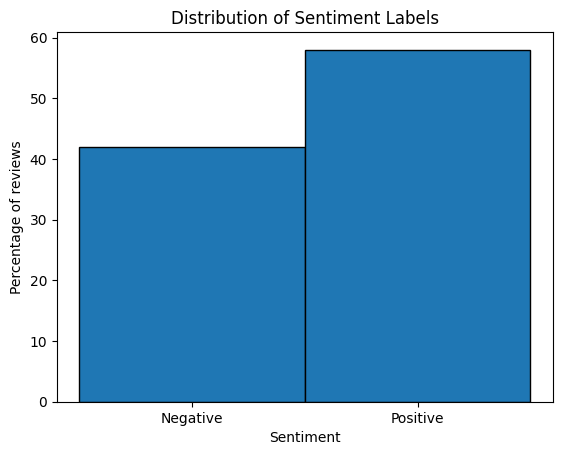

sentiment
negative    58
positive    42
Name: count, dtype: int64


In [55]:
plt.figure()
plt.hist(
    data["sentiment"],
    bins=[-0.5, 0.5, 1.5],
    edgecolor="black"
)

plt.xticks([0, 1], ["Negative", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Percentage of reviews")
plt.title("Distribution of Sentiment Labels")

plt.show()

print(data["sentiment"].value_counts())

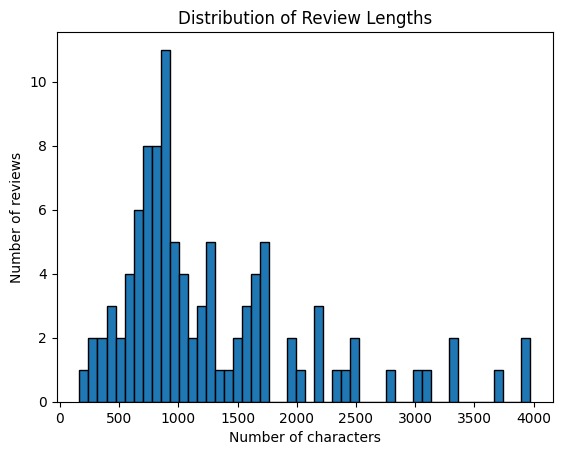

In [56]:
data["review_length"] = data["review"].str.len()

plt.figure()
plt.hist(data["review_length"], bins=50, edgecolor="black")
plt.xlabel("Number of characters")
plt.ylabel("Number of reviews")
plt.title("Distribution of Review Lengths")
plt.show()

In [57]:
print(data["sentiment"].unique())
label_map = {"negative": 0, "positive": 1}
data["sentiment"] = data["sentiment"].map(label_map)
print(data["sentiment"].unique())

['positive' 'negative']
[1 0]


# DistilBERT fine-tuned

https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english 

This model is a fine-tune checkpoint of DistilBERT-base-uncased, fine-tuned on SST-2 (general sentiment dataset)


In [59]:
from transformers import pipeline
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
classifier = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

texts = data["review"].astype(str).tolist()
true_labels = data["sentiment"].values  # 0/1

start_time = time.time()
predictions = classifier(texts, truncation=True)
end_time = time.time()
predicted_labels = [0 if pred["label"] == "NEGATIVE" else 1 for pred in predictions]

print(classification_report(true_labels, predicted_labels, target_names=["Negative", "Positive"]))
print(f"Prediction time for {len(texts)} samples: {end_time - start_time:.2f} seconds")


Device set to use mps:0


              precision    recall  f1-score   support

    Negative       0.86      0.95      0.90        58
    Positive       0.92      0.79      0.85        42

    accuracy                           0.88       100
   macro avg       0.89      0.87      0.87       100
weighted avg       0.88      0.88      0.88       100

Prediction time for 100 samples: 3.50 seconds


# RoBERTa-large fine-tuned

https://huggingface.co/siebert/sentiment-roberta-large-english

Fine-tuned and evaluated on 15 data sets from diverse text sources to enhance generalization across different types of texts (reviews, tweets, etc.)

In [63]:
classifier = pipeline(
    "sentiment-analysis",
    model="siebert/sentiment-roberta-large-english"
)

texts = data["review"].astype(str).tolist()
true_labels = data["sentiment"].values  # 0/1

start_time = time.time()
predictions = classifier(texts, truncation=True)
end_time = time.time()
predicted_labels = [0 if pred["label"] == "NEGATIVE" else 1 for pred in predictions]

print(classification_report(true_labels, predicted_labels, target_names=["Negative", "Positive"]))
print(f"Prediction time for {len(texts)} samples: {end_time - start_time:.2f} seconds")


Device set to use mps:0


              precision    recall  f1-score   support

    Negative       0.95      0.95      0.95        58
    Positive       0.93      0.93      0.93        42

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100

Prediction time for 100 samples: 28.80 seconds
